In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy


In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
import fastai; fastai.__version__

'1.0.54'

In [5]:
np.random.seed(42)

In [6]:
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [7]:
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [8]:
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [9]:
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [10]:
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [11]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [12]:
# src.add_test_folder('/home/ubuntu/snakes_breed/round1')

In [13]:
epochs = 40
lr = 1e-2
bs = 96
mixup = 0.2
image_size = 256

In [14]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[crop_pad()])

In [15]:
# tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [16]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize())

In [17]:
data

ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None

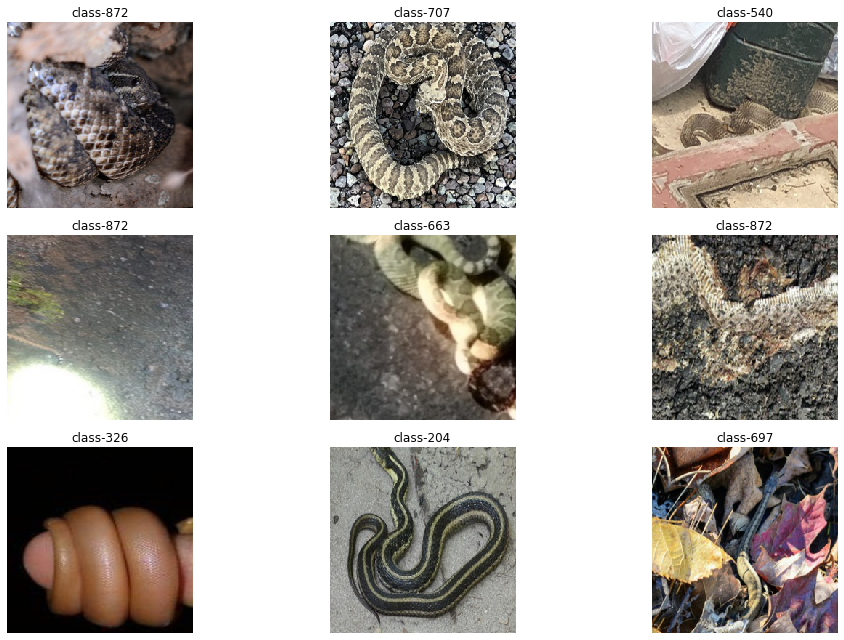

In [18]:
data.show_batch(3,figsize=(15,9))

In [19]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)


In [20]:
m = xresnet152(c_out=45)


In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
loss_func = FocalLoss(gamma=2.5)

In [22]:
learn = (Learner(data, m, opt_func=opt_func,
             metrics=[accuracy,FBeta(beta=1,average='macro')],
             bn_wd=False, true_wd=True,
             loss_func = loss_func)
            )

In [23]:
if mixup: learn = learn.mixup(alpha=mixup)


In [24]:
from fastai.metrics import accuracy, top_k_accuracy

top_2_accuracy = partial(top_k_accuracy, k=2)

In [25]:
learn.metrics = [accuracy,FBeta(beta=1,average='macro'),top_2_accuracy]

In [26]:
learn.load('c_xresnet-256-f1-round-2')

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type XResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ResBlock. It won'

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0

In [27]:
image_size=384
bs=48

In [28]:
data_new = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize())

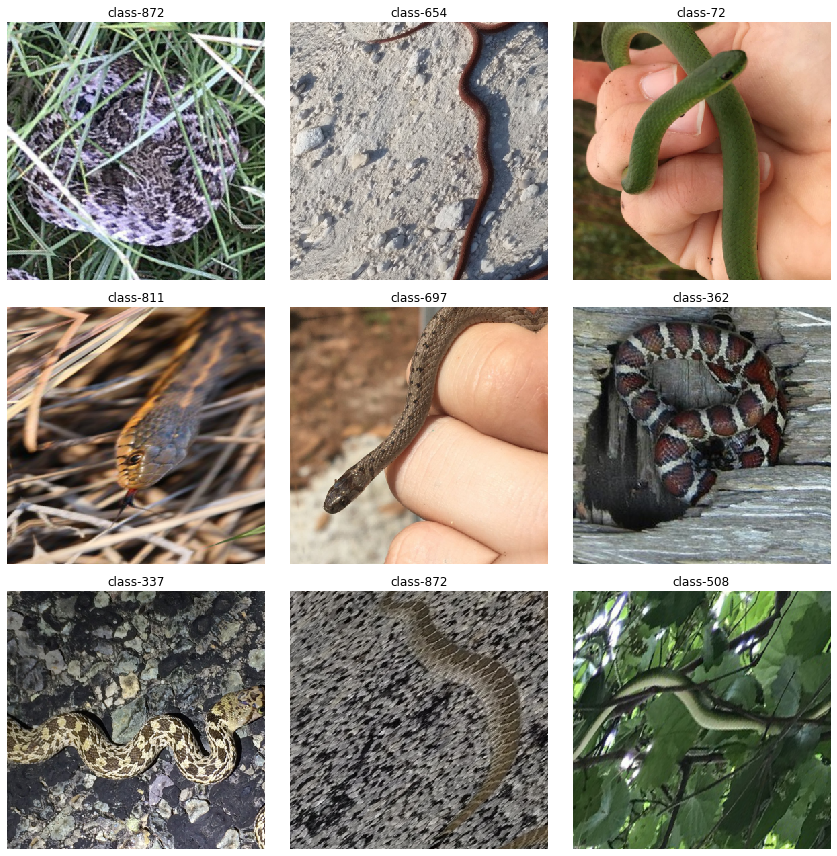

In [29]:
data_new.show_batch(3,figsize=(12,12))

In [30]:
learn.data = data_new

In [31]:
learn.data

ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None

In [32]:
learn = learn.to_fp16(dynamic=True)


In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [34]:
learn.metrics = [accuracy,FBeta(beta=1,average='macro'),top_2_accuracy]

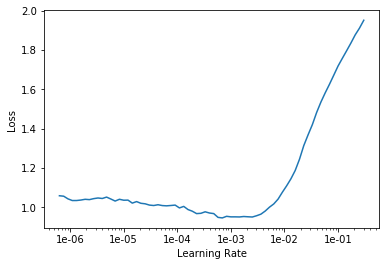

In [35]:
learn.recorder.plot()

In [36]:
lr=1e-4

In [37]:
learn.fit(10, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,0.778042,0.546029,0.788570,0.751509,0.878481,13:04
1,0.725819,0.543434,0.793424,0.754594,0.879998,13:06
2,0.721593,0.536835,0.796093,0.757131,0.880665,13:05
3,0.703558,0.544465,0.795426,0.753801,0.880968,13:03
4,0.681882,0.546389,0.795001,0.757047,0.878602,13:05
5,0.705001,0.550298,0.795790,0.755093,0.881332,13:04
6,0.682197,0.545505,0.795062,0.756568,0.879876,13:05
7,0.695912,0.532376,0.796275,0.758607,0.880180,13:05
8,0.685596,0.540385,0.795729,0.760297,0.880786,13:05
9,0.679669,0.559345,0.794334,0.759570,0.878238,13:06


In [38]:
learn.save('c_xresnet-384-f1-round-1')

In [39]:
lr=1e-5

In [40]:
learn.fit(10, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,0.666084,0.538021,0.798944,0.761606,0.883213,13:04
1,0.630413,0.536272,0.800340,0.763228,0.882849,13:03
2,0.657737,0.535661,0.800886,0.763027,0.883577,13:05
3,0.652674,0.538930,0.801007,0.763332,0.883092,13:05
4,0.642831,0.543933,0.800704,0.763694,0.881878,13:04
5,0.636973,0.537723,0.800643,0.763486,0.883213,13:05
6,0.642322,0.532158,0.803980,0.767763,0.884487,13:05
7,0.643646,0.541694,0.802584,0.765588,0.883213,13:03
8,0.617070,0.540130,0.803555,0.767466,0.883880,13:05
9,0.613818,0.540808,0.800522,0.764989,0.884184,13:05


In [41]:
learn.save('c_xresnet-384-round-2')

In [42]:
lr=1e-6

In [43]:
learn.fit(10,lr)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,0.640908,0.538416,0.801978,0.764941,0.883880,13:04
1,0.621786,0.538776,0.801674,0.766208,0.884123,13:06
2,0.629038,0.535184,0.802099,0.766141,0.884548,13:07
3,0.634020,0.540644,0.801796,0.764340,0.883759,13:06
4,0.608503,0.544021,0.800764,0.763763,0.883577,13:05
5,0.641372,0.538465,0.802524,0.766091,0.884608,13:05
6,0.635450,0.541789,0.802402,0.766383,0.884548,13:07
7,0.612070,0.537416,0.802342,0.765292,0.883820,13:04
8,0.642063,0.537085,0.800461,0.764293,0.884366,13:06
9,0.626580,0.538133,0.801007,0.764471,0.884608,13:05


In [44]:
learn.save('c_xresnet-384-round-3')

In [51]:
learn.load('c_xresnet-384-round-3')

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type XResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ResBlock. It won'

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0

In [54]:
learn.loss_func = FocalLoss(gamma=2.)

In [55]:
learn.validate()

[0.57847804, tensor(0.8010), tensor(0.7683), tensor(0.8846)]

In [56]:
learn.fit(2,lr)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,0.664759,0.563428,0.801856,0.766168,0.884851,13:05
1,0.639633,0.560163,0.802827,0.765765,0.885276,13:05


In [57]:
interp = ClassificationInterpretation.from_learner(learn)


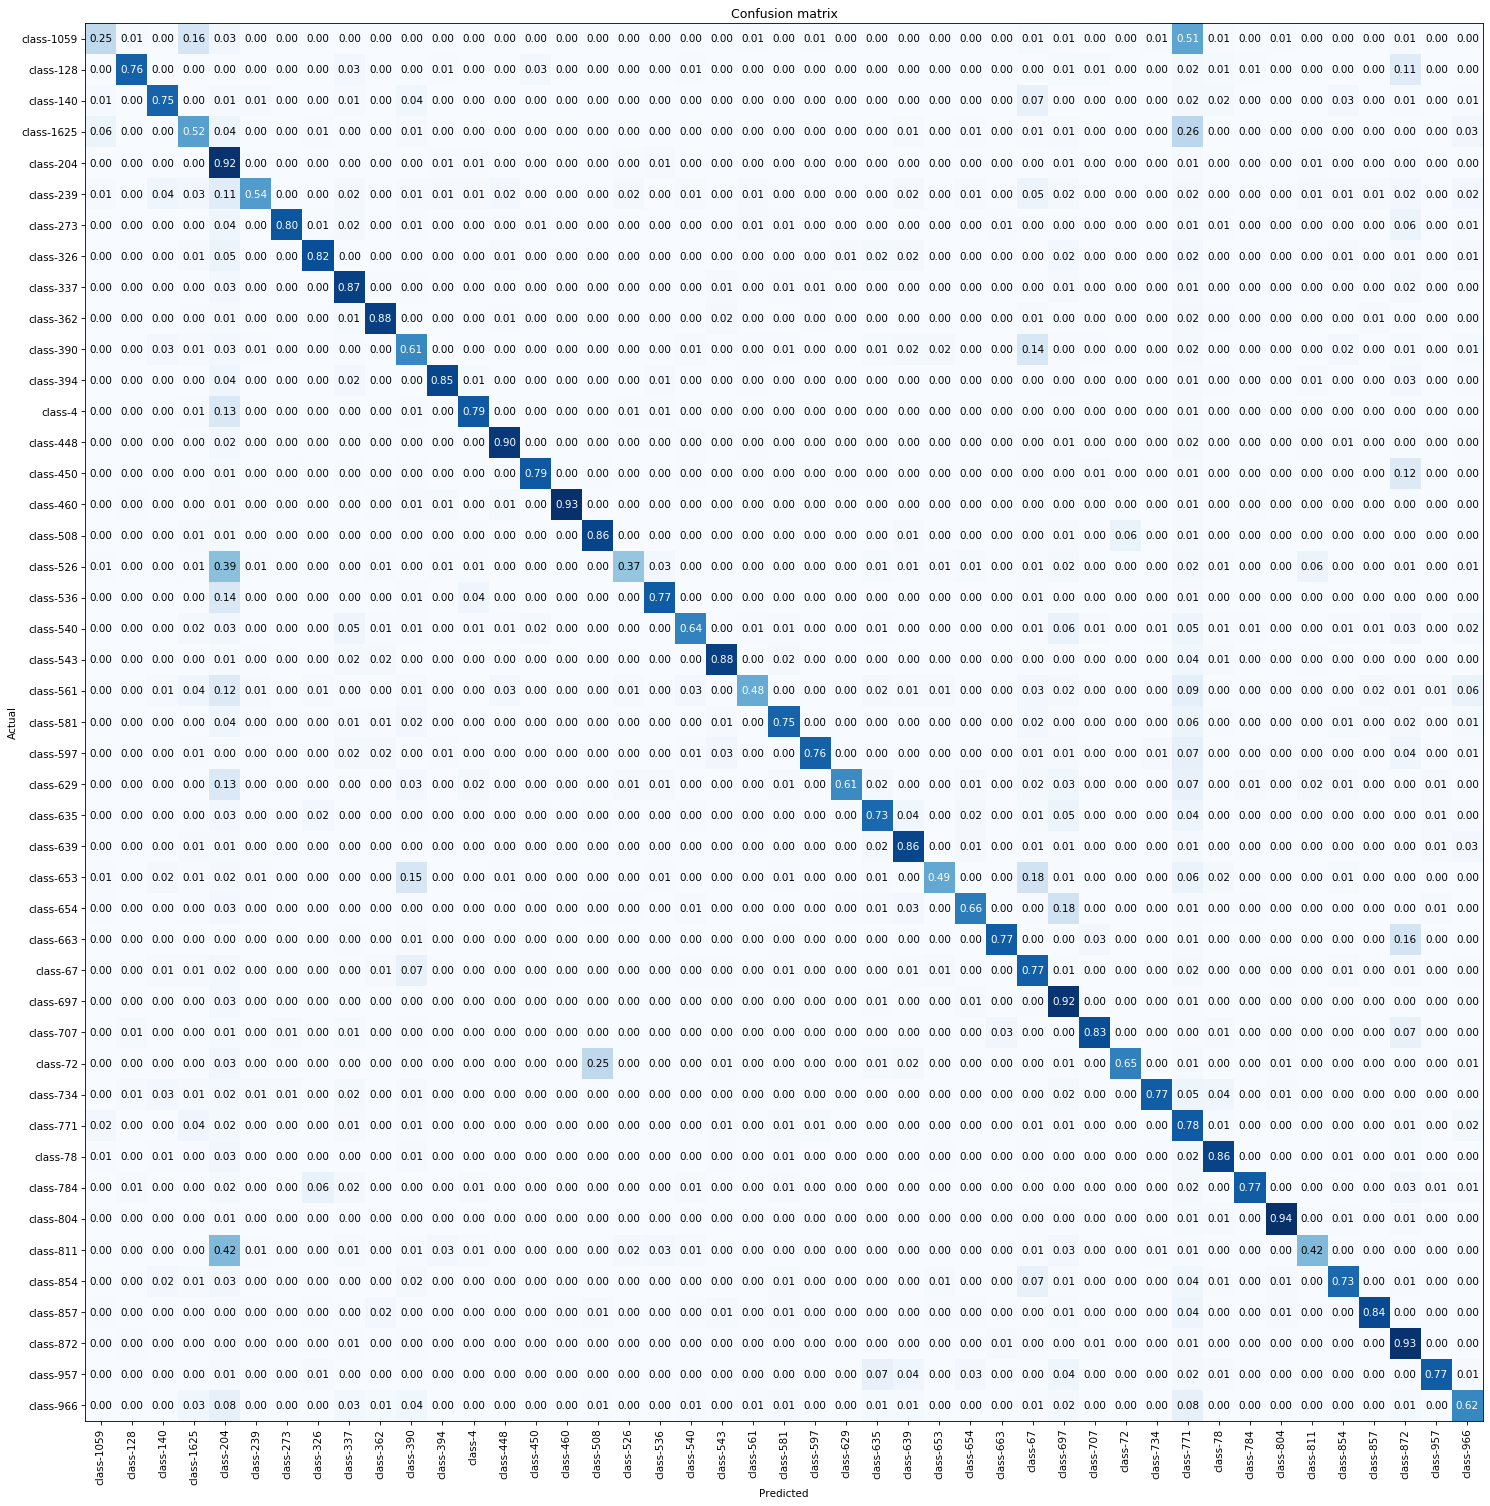

In [58]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=True)


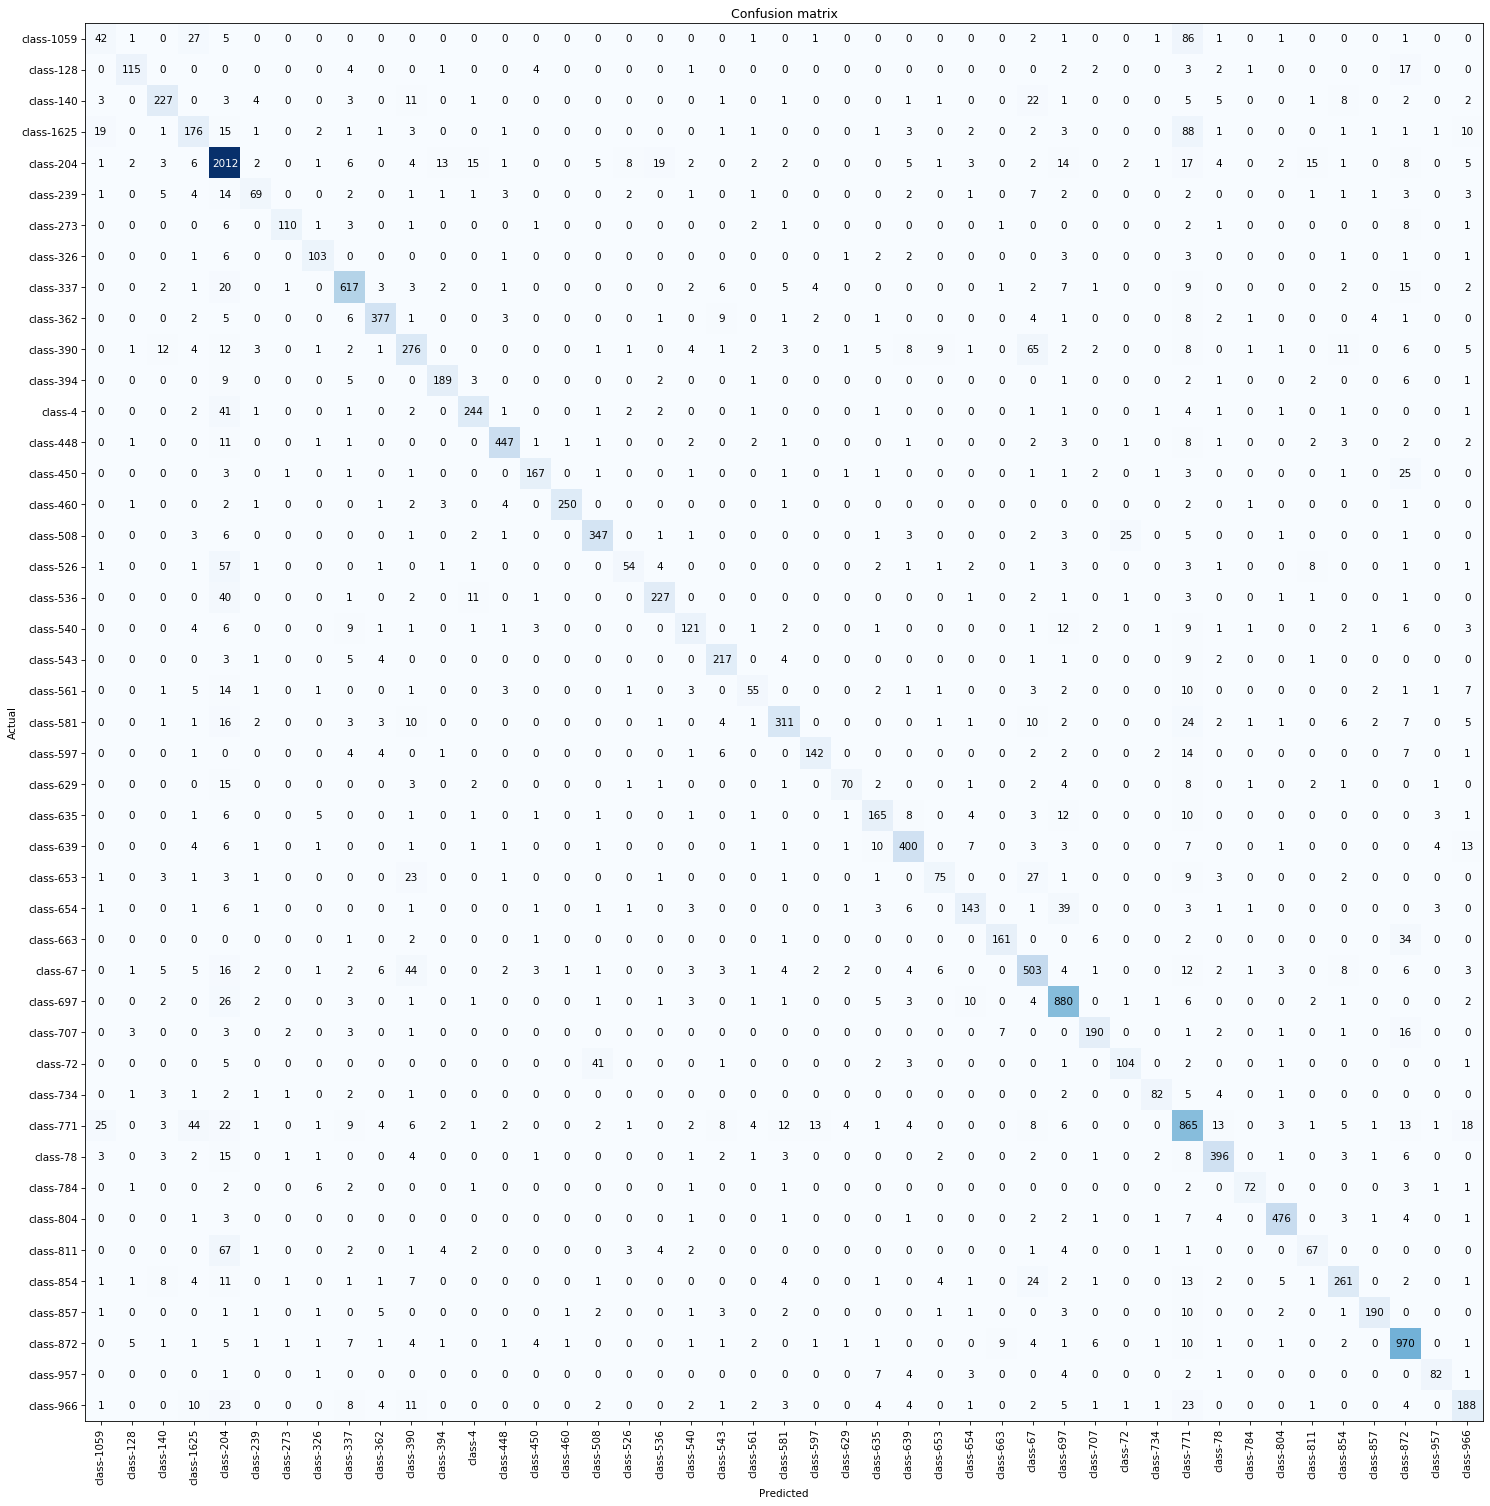

In [59]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=False)

In [60]:
interp.plot_top_losses(6, figsize=(30,22))

TypeError: len() of a 0-d tensor

In [61]:
learn.save('c_xresnet-384-round-4')

In [62]:
learn.loss_func = LabelSmoothingCrossEntropy()

In [63]:
learn.fit(2,lr)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,1.338870,1.330385,0.803616,0.766888,0.889401,13:05
1,1.340610,1.322621,0.804526,0.765673,0.889705,13:06


In [64]:
learn.save('c_xresnet-384-round-5')

In [69]:
lr=1e-5

In [ ]:
learn.fit(2,lr)

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,1.330227,1.316504,0.805557,0.765592,0.889462,13:04


In [ ]:
learn.save('c_xresnet-384-round-6')